<a href="https://colab.research.google.com/github/infiniteoverflow/Fashion-MNIST---Pytorch/blob/master/Fashion_MNIST_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from torchvision import datasets,transforms
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F

In [100]:
transform = transforms.Compose([ transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

trainset = datasets.FashionMNIST('/tmp/fashion',train=True,transform=transform,download=True)
testset = datasets.FashionMNIST('/tmp/fashion',train=False,transform=transform,download=True)


Extracting /tmp/fashion/FashionMNIST/raw/train-images-idx3-ubyte.gz to /tmp/fashion/FashionMNIST/raw



Extracting /tmp/fashion/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /tmp/fashion/FashionMNIST/raw


Extracting /tmp/fashion/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/fashion/FashionMNIST/raw


Extracting /tmp/fashion/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/fashion/FashionMNIST/raw
Processing...
Done!


In [0]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# obtain training indices that will be used for validation
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
    num_workers=num_workers)

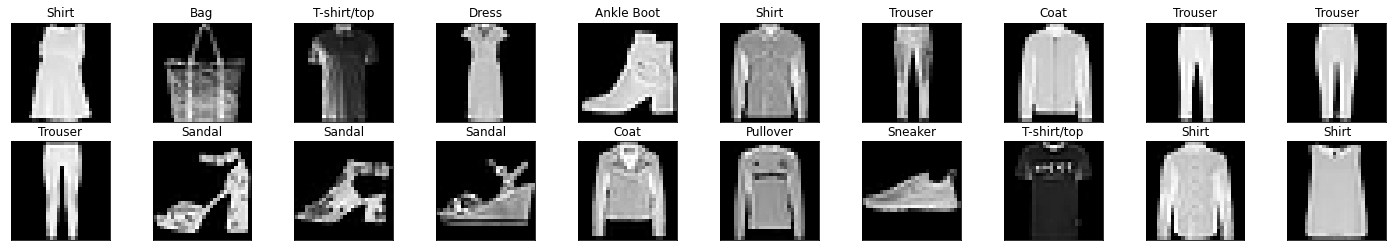

In [108]:

import matplotlib.pyplot as plt
%matplotlib inline

classes = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(classes[labels.numpy()[idx]]))


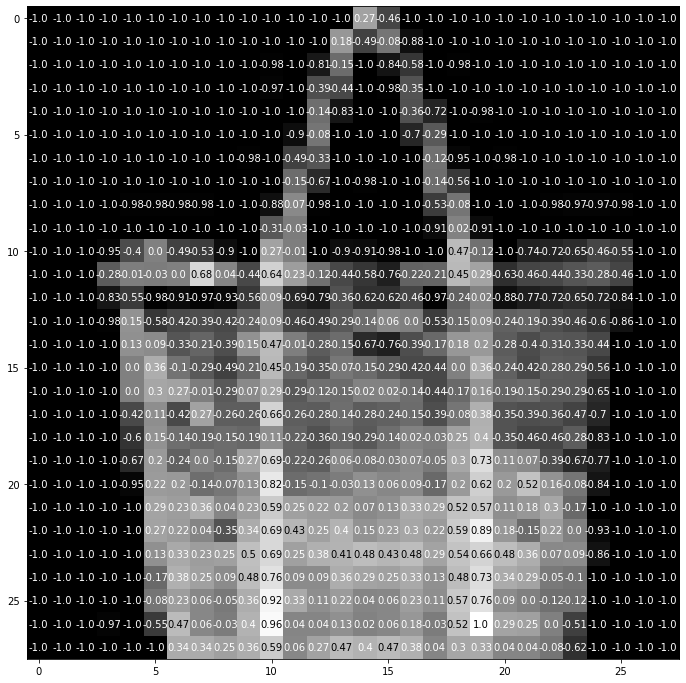

In [109]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')


In [110]:
img.shape

(28, 28)

# Defining the Neural Network architecture

In [0]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1,8,3)
    self.conv2 = nn.Conv2d(8,16,3)
    
    self.maxpool = nn.MaxPool2d(2)
    
    self.fc1 = nn.Linear(400,512)
    self.fc2 = nn.Linear(512,10)

    self.dropout = nn.Dropout(0.2)

  def forward(self,x):
    x = self.maxpool(F.relu(self.conv1(x)))

    x = self.maxpool(F.relu(self.conv2(x)))

    x = x.view(-1,400)

    x = self.dropout(x)
    x = F.relu(self.fc1(x))

    x = self.dropout(x)
    x = self.fc2(x)

    return x

model = Network()

In [113]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

In [115]:
model

Network(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(),lr=0.01)

In [117]:
epochs = 20

valid_loss_min = np.inf

for epoch in range(epochs):

  training_loss = 0
  valid_loss = 0

  model.train()

  for image,label in train_loader:

    if train_on_gpu:
      image , label = image.cuda(),label.cuda()

    optimizer.zero_grad()

    output = model(image)

    loss = criterion(output,label)

    loss.backward()

    optimizer.step()

    training_loss += loss.item()*image.size(0)

  model.eval()
  for data, target in valid_loader:
      if train_on_gpu:
          data, target = data.cuda(), target.cuda()

      output = model(data)

      loss = criterion(output, target)

      valid_loss += loss.item()*data.size(0)
    
  # calculate average losses
  training_loss = training_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(valid_loader.sampler)
      
  # print training/validation statistics 
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
      epoch, training_loss, valid_loss))

  # save model if validation loss has decreased
  if valid_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
      valid_loss_min,
      valid_loss))
      torch.save(model.state_dict(), 'model_cifar.pt')
      valid_loss_min = valid_loss

Epoch: 0 	Training Loss: 0.863871 	Validation Loss: 0.542204
Validation loss decreased (inf --> 0.542204).  Saving model ...
Epoch: 1 	Training Loss: 0.543581 	Validation Loss: 0.446433
Validation loss decreased (0.542204 --> 0.446433).  Saving model ...
Epoch: 2 	Training Loss: 0.485254 	Validation Loss: 0.416993
Validation loss decreased (0.446433 --> 0.416993).  Saving model ...
Epoch: 3 	Training Loss: 0.451507 	Validation Loss: 0.387859
Validation loss decreased (0.416993 --> 0.387859).  Saving model ...
Epoch: 4 	Training Loss: 0.426721 	Validation Loss: 0.375752
Validation loss decreased (0.387859 --> 0.375752).  Saving model ...
Epoch: 5 	Training Loss: 0.405615 	Validation Loss: 0.354658
Validation loss decreased (0.375752 --> 0.354658).  Saving model ...
Epoch: 6 	Training Loss: 0.391029 	Validation Loss: 0.342377
Validation loss decreased (0.354658 --> 0.342377).  Saving model ...
Epoch: 7 	Training Loss: 0.379749 	Validation Loss: 0.335138
Validation loss decreased (0.34237

In [118]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [119]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# specify the image classes

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.298891

Test Accuracy of T-shirt/top: 83% (831/1000)
Test Accuracy of Trouser: 98% (984/1000)
Test Accuracy of Pullover: 80% (806/1000)
Test Accuracy of Dress: 91% (911/1000)
Test Accuracy of  Coat: 86% (863/1000)
Test Accuracy of Sandal: 98% (982/1000)
Test Accuracy of Shirt: 66% (666/1000)
Test Accuracy of Sneaker: 94% (941/1000)
Test Accuracy of   Bag: 97% (972/1000)
Test Accuracy of Ankle Boot: 96% (966/1000)

Test Accuracy (Overall): 89% (8922/10000)


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(img,cmap='gray')  # convert from Tensor image


In [121]:

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy().squeeze() # convert images to numpy for display

images.shape

images[1].shape

(28, 28)

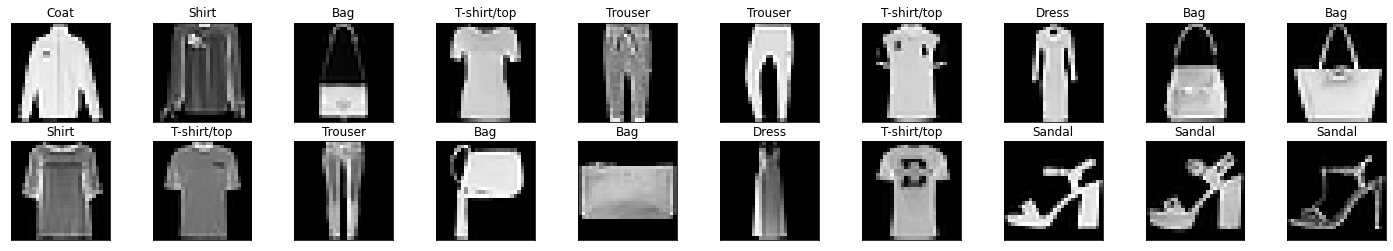

In [122]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])